# setup

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys
sys.path.append("/usr/local/Cellar/opencv3/3.2.0/lib/python3.5/site-packages/") # mac opencv path
import cv2
import numpy as np
from typing import Tuple, List, Text, Dict, Any, Iterator
import time


def mtx_plot(fnmtx, ratio):
    h = len(fnmtx[0])
    w = len(fnmtx)
    k = 1
    fig = plt.figure(figsize=(ratio[0]*h, ratio[1]*w))
    for fnarr in fnmtx:
        for fn in fnarr:
            fig.add_subplot(w,h,k)
            fn(k)
            k += 1

# prediction

In [11]:
import keras.backend as  K
from keras.models import model_from_json
import skimage.io as io
from model_unet import create_unet

with K.tf.device('/cpu:0'):
        model = create_unet((256, 256, 3), 64, "integrated")
        #model.load_weights("./data/2017-05-16-05-03-19_float32_integrated_fil64_adam_lr0.0001_glorot_uniform_shape256x256_batch_size8_data_aug_weights.epoch0004-val_loss941.21-val_acc0.06.hdf5")
        model.load_weights("./data/2017-05-16-05-05-41_float32_integrated_fil64_adam_lr0.0001_glorot_uniform_shape256x256_batch_size8_data_aug_weights.epoch0005-val_loss920.41-val_acc0.04.hdf5")


(1, 256, 256, 3) (1, 256, 256) (1, 256, 256)


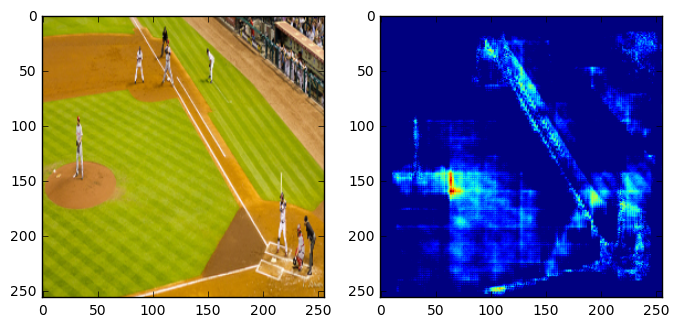

In [18]:
'''
COCO_val2014_000000000589
COCO_val2014_000000000139
COCO_val2014_000000000257
COCO_val2014_000000000283
COCO_val2014_000000000328
COCO_val2014_000000000338
COCO_val2014_000000000357
'''

img = io.imread("./data/val2014/COCO_val2014_000000000357.jpg")
img = cv2.resize(img, (256, 256))
img = np.expand_dims(img, axis=0)


with K.tf.device('/cpu:0'):
        output = model.predict(img)
        print(img.shape, output.shape, output.shape)



mat1 = [
    [
        lambda x: plt.imshow(img[0]),
        lambda x: plt.imshow(output[0]),
    ]
]

mtx_plot(mat1, ratio=(4,4))